# MAP Analysis Pipeline

This notebook provides a comprehensive workflow for running MAP (Molecular ALS Phenotype) analysis on imaging data. It combines model training with detailed explanations of each step in the pipeline.

## Overview

The MAP analysis framework enables classification of cell lines based on morphological imaging features. This notebook demonstrates:

1. **Data Loading**: Using `ImageScreenMultiAntibody` to load multi-marker imaging data
2. **Preprocessing**: Quality control and feature engineering steps
3. **Model Training**: Training classification models with leave-one-out cross-validation
4. **Evaluation**: Generating predictions and assessing model performance
5. **Post-hoc Analysis**: Adjusting for technical covariates and visualizing results

## 1. Setup and Configuration

In [9]:
# ---- Analysis Parameters ----
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "binary"  # Analysis type: binary_loocv, multiclass, etc.
MARKER = "all"  # "all" or specific marker name to filter
ANTIBODY = "FUS/EEA1"  # Can be single antibody or list of antibodies

# ---- Color Palette for Visualizations ----
PALETTE = {
    "WT": "#9A9A9A",
    "FUS": "#B24745",
    "C9orf72": "#6A6599",
    "sporadic": "#79AF97",
    "SOD1": "#00A1D5",
    "TDP43": "#DF8F44"
}

In [10]:
import os
import random
import numpy as np
import torch

# ---- Set seeds for reproducibility ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seeds set for reproducibility")

Random seeds set for reproducibility


## 2. Load Analysis Parameters

MAPs analysis parameters are stored in JSON configuration files that specify:

- **Screen information**: Dataset paths and metadata
- **Preprocessing steps**: Feature selection, transformations, and quality control
- **Model configuration**: Architecture, training parameters, and evaluation strategy
- **Analysis settings**: Cross-validation scheme, response variables, and grouping factors

Parameters are loaded as a dict and passed to `maps` classes to specifiy analyses configurations. Parameters can be changed within your python script. For example, in the block below, we manually override the `screen`, `antibodies`, and `preprocessing` (to drop selected antibodies) fields of our parameter file. Overwriting parameter fields can be useful when running pipelines that iterate over a range of parameters (e.g., biomarkers). Best practice is to use placeholders in varied parameter fields that indicate it will be changed within a script.  

In [11]:
from maps.screens import ImageScreenMultiAntibody
import json
from pathlib import Path

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/pipelines/params")
with open(pdir / f"{ANALYSIS}.json", "r") as f:
    params = json.load(f)

params["screen"] = SCREEN
params["antibodies"] = ANTIBODY

# Update marker if specified
if MARKER != "all":
    fstr = params["preprocess"]["drop_feature_types"]["feature_str"]
    fstr += f"|^.*{MARKER}.*$"
    params["preprocess"]["drop_feature_types"]["feature_str"] = fstr

# Display configuration
print("Analysis Configuration:")
print(json.dumps(params, indent=4))

Analysis Configuration:
{
    "name": "binary",
    "description": "Binary classification analysis. Models trained on classify a single ALS genetic background vs health. Genetic-specific models applied to all ALS genetic backgrounds in eval set.",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "antibodies": "FUS/EEA1",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "result_dir": "/home/kkumbier/als/analysis_results",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048",
                        "FTD37"
                    ]
                },
                {
                    "Mutations": [
                        "TDP43"
                    ]
                }
    

## 3. Initialize Screen and Load Data


The `ImageScreenMultiAntibody` class is designed to handle data I/O for multiple antibody markers simultaneously, allowing for multi-modal analysis. Each marker set is processed independently during preprocessing but can be integrated during model training. 

The `ImageScreenMultiAntibody` class provides utilities for:

- **Listing available markers**: Scan the dataset to identify all available antibody combinations
- **Loading marker data**: Load imaging features for specified antibody sets
- **Managing metadata**: Track cell line information, mutation status, and experimental conditions

Data and metadata for multi-antibody screens are stored as Python dictionaries, keyed by marker set names. This structure allows flexible analysis of single or multiple markers. *Note:* previous versions of the `maps` used the `ImageScreen` class. While this class can still be used for a single marker set analysis, it is recommended to use `ImageScreenMultiAntibody` with a single marker set to ensure consistent formatting of data/metadata format.

In [12]:
# Initialize screen class
screen = ImageScreenMultiAntibody(params)

# Display available antibody combinations
print("Available antibody combinations in dataset:")
available_antibodies = screen.loader.list_antibodies().unique()
for ab in available_antibodies:
    print(f"  - {ab}")

Available antibody combinations in dataset:
  - Rab1/CHMP2B
  - pTDP43/HMOX1
  - p62/LC3
  - CD63/SEC16A
  - COX IV/Galectin3/atubulin
  - HSP70/SOD1
  - TDP43_abcam/G3BP1
  - LAMP/TDP43-C
  - FUS/EEA1


In [13]:
# Load data for specified antibody/antibodies
print(f"\nLoading data for: {params['antibodies']}")
screen.load(antibody=params["antibodies"])

# Display loaded data structure
print("\nLoaded data structure:")
print(f"Data type: {type(screen.data)}")
if isinstance(screen.data, dict):
    for ab, data in screen.data.items():
        print(f"  {ab}: {data.shape if hasattr(data, 'shape') else type(data)}")


Loading data for: FUS/EEA1

Loaded data structure:
Data type: <class 'dict'>
  FUS/EEA1: (236027, 4723)

Loaded data structure:
Data type: <class 'dict'>
  FUS/EEA1: (236027, 4723)


## 4. Data Preprocessing

Preprocessing transforms raw imaging features into analysis-ready data. The preprocessing pipeline typically includes:

### Quality Control Steps:
- **`drop_sample_by_feature`**: Remove cell lines with abnormal characteristics (e.g., unusually low cell counts)
- **`drop_cells_by_feature_qt`**: Filter outlier cells based on quantile thresholds for size metrics
  - Removes cells below 5th or above 95th percentiles in nuclear/cell region size
  - Helps screen out segmentation artifacts and debris

### Feature Engineering:
- **`select_feature_types`**: Filter to specific feature categories (e.g., intensity features only)
- **`drop_feature_types`**: Remove unwanted feature types (e.g., segmentation channels)

### Sampling:
- **`subsample_rows_by_id`**: Balanced sampling of cells per well
  - **Critical step** to prevent training biases
  - Ensures equal representation of each cell line
  - Without this, over-represented cell lines can dominate the model
  - Some models (e.g., MultiAntibodyClassifier) automate class balancing, so this step is no longer required.

**Note**: The exact preprocessing steps should be tailored to your specific dataset. For example, cell lines flagged in QC may differ across experiments.

In [6]:
print("Processing data...")
screen.preprocess()
assert screen.data is not None, "Data loading or preprocessing failed"

# Display processed data information
print("\nProcessed data summary:")
for ab in params["antibodies"] if isinstance(params["antibodies"], list) else [params["antibodies"]]:
    print(f"\nMarker set: {ab}")
    print(f"Data shape: {screen.data[ab].shape}")
    print(f"Features: {screen.data[ab].columns[:10]}...")  # Show first 10 features
    
    # Show example of transformed data
    if hasattr(screen.data[ab], 'head'):
        print(f"\nSample data:")
        display(screen.data[ab].head())

Processing data...
Preprocessing complete

Processed data summary:

Marker set: FUS/EEA1
Data shape: (115816, 315)
Features: ['Total_Spot_Area', 'Relative_Spot_Intensity', 'Number_of_Spots', 'Number_of_Spots_per_Area_of_Cell', 'Total_Spot_Area_(2)', 'Relative_Spot_Intensity_(2)', 'Number_of_Spots_(2)', 'Number_of_Spots_per_Area_of_Cell_(2)', 'Spot1_overlap_spot2_ROI_Border_Distance_[µm]', 'Spot1_overlap_spot2_Overlap_[%]']...

Sample data:
Preprocessing complete

Processed data summary:

Marker set: FUS/EEA1
Data shape: (115816, 315)
Features: ['Total_Spot_Area', 'Relative_Spot_Intensity', 'Number_of_Spots', 'Number_of_Spots_per_Area_of_Cell', 'Total_Spot_Area_(2)', 'Relative_Spot_Intensity_(2)', 'Number_of_Spots_(2)', 'Number_of_Spots_per_Area_of_Cell_(2)', 'Spot1_overlap_spot2_ROI_Border_Distance_[µm]', 'Spot1_overlap_spot2_Overlap_[%]']...

Sample data:


Total_Spot_Area,Relative_Spot_Intensity,Number_of_Spots,Number_of_Spots_per_Area_of_Cell,Total_Spot_Area_(2),Relative_Spot_Intensity_(2),Number_of_Spots_(2),Number_of_Spots_per_Area_of_Cell_(2),Spot1_overlap_spot2_ROI_Border_Distance_[µm],Spot1_overlap_spot2_Overlap_[%],Spot2_overlap_spot1_ROI_Border_Distance_[µm],Spot2_overlap_spot1_Overlap_[%],Intensity_Nucleus_Region_Alexa_488_Mean,Intensity_Nucleus_Region_Alexa_488_StdDev,Intensity_Nucleus_Region_Alexa_488_Median,Intensity_Nucleus_Region_Alexa_488_Maximum,Intensity_Nucleus_Region_Alexa_488_Minimum,Intensity_Nucleus_Region_Alexa_488_CV_[%],Intensity_Nucleus_Region_Alexa_488_Quantile_90%,Intensity_Nucleus_Region_Alexa_488_Contrast,Nucleus_Region_Alexa_488_Symmetry_02_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_03_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_04_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_05_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_12_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_13_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_14_SER-Spot,Nucleus_Region_Alexa_488_Symmetry_15_SER-Spot,Nucleus_Region_Alexa_488_Threshold_Compactness_30%_SER-Spot,Nucleus_Region_Alexa_488_Threshold_Compactness_40%_SER-Spot,Nucleus_Region_Alexa_488_Threshold_Compactness_50%_SER-Spot,Nucleus_Region_Alexa_488_Threshold_Compactness_60%_SER-Spot,Nucleus_Region_Alexa_488_Axial_Small_Length_SER-Spot,Nucleus_Region_Alexa_488_Axial_Length_Ratio_SER-Spot,Nucleus_Region_Alexa_488_Radial_Mean_SER-Spot,Nucleus_Region_Alexa_488_Radial_Relative_Deviation_SER-Spot,Nucleus_Region_Alexa_488_Radial_Mean_Ratio_SER-Spot,…,Cell_Region_Alexa_647_Profile_1/5_SER-Spot,Cell_Region_Alexa_647_Profile_2/5_SER-Spot,Cell_Region_Alexa_647_Profile_3/5_SER-Spot,Cell_Region_Alexa_647_Profile_4/5_SER-Spot,Cell_Region_Alexa_647_Profile_5/5_SER-Spot,Cell_Region_Alexa_647_SER_Spot_2_px,Intensity_Membrane_Region_Alexa_647_Mean,Intensity_Membrane_Region_Alexa_647_StdDev,Intensity_Membrane_Region_Alexa_647_Median,Intensity_Membrane_Region_Alexa_647_Maximum,Intensity_Membrane_Region_Alexa_647_Minimum,Intensity_Membrane_Region_Alexa_647_CV_[%],Intensity_Membrane_Region_Alexa_647_Quantile_90%,Intensity_Membrane_Region_Alexa_647_Contrast,Membrane_Region_Alexa_647_Symmetry_02_SER-Spot,Membrane_Region_Alexa_647_Symmetry_03_SER-Spot,Membrane_Region_Alexa_647_Symmetry_04_SER-Spot,Membrane_Region_Alexa_647_Symmetry_05_SER-Spot,Membrane_Region_Alexa_647_Symmetry_12_SER-Spot,Membrane_Region_Alexa_647_Symmetry_13_SER-Spot,Membrane_Region_Alexa_647_Symmetry_14_SER-Spot,Membrane_Region_Alexa_647_Symmetry_15_SER-Spot,Membrane_Region_Alexa_647_Threshold_Compactness_30%_SER-Spot,Membrane_Region_Alexa_647_Threshold_Compactness_40%_SER-Spot,Membrane_Region_Alexa_647_Threshold_Compactness_50%_SER-Spot,Membrane_Region_Alexa_647_Threshold_Compactness_60%_SER-Spot,Membrane_Region_Alexa_647_Axial_Small_Length_SER-Spot,Membrane_Region_Alexa_647_Axial_Length_Ratio_SER-Spot,Membrane_Region_Alexa_647_Radial_Mean_SER-Spot,Membrane_Region_Alexa_647_Radial_Relative_Deviation_SER-Spot,Membrane_Region_Alexa_647_Radial_Mean_Ratio_SER-Spot,Membrane_Region_Alexa_647_Profile_1/5_SER-Spot,Membrane_Region_Alexa_647_Profile_2/5_SER-Spot,Membrane_Region_Alexa_647_Profile_4/5_SER-Spot,Membrane_Region_Alexa_647_Profile_5/5_SER-Spot,Membrane_Region_Alexa_647_SER_Spot_2_px,ID
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
2058.0,0.313345,99.0,0.007156,265.0,0.025484,27.0,0.001952,0.0,4.12822,0.0,31.835199,22933.199219,8657.5,21586.0,53120.0,8973.0,37.750999,35112.0,-0.015106,0.330032,0.293618,0.155678,0.156652,0.368044,0.257938,0.090929,0.12726,0.831355,0.835543,0.947416,1.25331,6.77356,0.633681,8.69176,0.2447,1.08853,…,0.003024,0.003019,0.004353,0.001697,0.000171,0.002979,968.552979,482.057007,830.0,9015.0,631.0,49.770901,1273

## 5. Model Training

The `MAP` class provides a unified interface for model training and evaluation:

- **Initialization**: The MAP class is initialized with a `Screen` object
- **Configuration**: Training parameters (model type, fitting strategy) are read from the screen's parameter file
- **Fitting**: The `fit()` method executes the complete training workflow

### Model Types:
- **Single-marker models**: Traditional ML models (logistic regression, random forest, etc.)
- **Multi-marker models**: PyTorch-based models that integrate data across markers
  - Allows flexible integration strategies (concatenation, attention mechanisms, etc.)
  - Suitable for learning marker interactions and multi-modal representations

### Training Strategy:
- **Leave-one-out cross-validation (LOOCV)**: Each mutation group is held out in turn
- **Sample split**: Cell lines are divided into two sets with equal class representation, models are trained on one set & evaluated on the other, then the process is repeated with training and eval sets swapped.

In [7]:
from maps.analyses import MAP

print("Initializing MAP analysis...")
map_analysis = MAP(screen)

print("Training model...")
print("This may take several minutes depending on dataset size and model complexity.\n")
map_analysis.fit()

print("\nModel training complete!")

Initializing MAP analysis...
Training model...
This may take several minutes depending on dataset size and model complexity.

Training C9orf72...
--- Replicate 1/3 ---
Starting cell-level training...
Starting cell-level training...
Cell Epoch 1/100, Overall Loss: 0.7508, Active: 1/1
  FUS/EEA1 - Loss: 0.7508, Acc: 0.5063 
Cell Epoch 1/100, Overall Loss: 0.7508, Active: 1/1
  FUS/EEA1 - Loss: 0.7508, Acc: 0.5063 
Cell Epoch 2/100, Overall Loss: 0.7035, Active: 1/1
  FUS/EEA1 - Loss: 0.7035, Acc: 0.5455 
Cell Epoch 2/100, Overall Loss: 0.7035, Active: 1/1
  FUS/EEA1 - Loss: 0.7035, Acc: 0.5455 
Cell Epoch 3/100, Overall Loss: 0.7005, Active: 1/1
  FUS/EEA1 - Loss: 0.7005, Acc: 0.5648 
Cell Epoch 3/100, Overall Loss: 0.7005, Active: 1/1
  FUS/EEA1 - Loss: 0.7005, Acc: 0.5648 
Cell Epoch 4/100, Overall Loss: 0.7167, Active: 1/1
  FUS/EEA1 - Loss: 0.7167, Acc: 0.5440 
Cell Epoch 4/100, Overall Loss: 0.7167, Active: 1/1
  FUS/EEA1 - Loss: 0.7167, Acc: 0.5440 
Cell Epoch 5/100, Overall Loss: 

## 6. Examine Predictions

The fitted MAP object contains predictions for each mutation group. For single-marker models, predictions are organized by mutation type. For multi-marker models, predictions may be stored differently depending on the model architecture.

### Prediction Structure:
- **Cell-level predictions**: Individual MAP scores for each cell
- **Metadata**: Cell line, mutation status, well information
- **Model outputs**: Predicted probabilities or class labels

These predictions can be aggregated and analyzed at various levels (cell, well, cell line) for downstream analysis.

In [ ]:
# Display prediction structure
print("Prediction structure:")
print(f"Type: {type(map_analysis.fitted)}")

# For single-marker LOOCV models
print(f"\nMutation groups analyzed: {list(map_analysis.fitted.keys())}")

# Show example predictions for first mutation group
first_mut = list(map_analysis.fitted.keys())[0]
print(f"\nExample predictions for {first_mut}:")
if "predicted" in map_analysis.fitted[first_mut]:
    display(map_analysis.fitted[first_mut]["predicted"].head())
    
    # Show model parameters
    if hasattr(map_analysis.model, 'model') and hasattr(map_analysis.model.model, 'params'):
        print(f"\nModel parameters:")
        print(map_analysis.model.model.params)

# For multi-marker models
print("\nMulti-marker model predictions:")
display(map_analysis.fitted["predicted"].head(24))

Prediction structure:
Type: <class 'dict'>

Mutation groups analyzed: ['C9orf72', 'SOD1', 'FUS']

Example predictions for C9orf72:


Class_0,Class_1,CellLines,True
f32,f32,str,i64
0.787107,0.212893,"""CRL-2201""",0
0.768333,0.231667,"""C9012""",1
0.75561,0.244391,"""GIH166""",0
0.722425,0.277575,"""ALS32""",1
0.720936,0.279064,"""11""",0


## 7. Post-hoc Analysis: Count Adjustment

MAP scores can be influenced by technical factors such as cell count per well. To adjust for these effects:

### Count Adjustment Process:
1. **Aggregate to well-level**: Group cell-level predictions by well
2. **Fit size model**: Estimate MAP scores as a function of cell count
3. **Adjust predictions**: Remove the estimated count effect from raw MAP scores

This adjustment helps isolate biological signal from technical variation, improving the reliability of downstream comparisons.

### When to Apply:
- When cell counts vary substantially across wells
- When quality control reveals count-dependent bias in MAP scores
- Before making quantitative comparisons between cell lines or conditions

In [ ]:
import pandas as pd
import polars as pl
from maps.utils import group_predicted, fit_size_model, adjust_map_scores

import pandas as pd
import statsmodels.api as sm
import polars as pl
import numpy as np
import re

adjusted = {}
groups = ["CellLines", "Mutations"] 

# Extract mapping from CellLines to Mutations
cell_line_to_mutation = next(iter(screen.metadata.values())) \
    .select(["CellLines", "Mutations"]) \
    .unique() \
    .to_pandas() \
    .set_index("CellLines")["Mutations"] \
    .to_dict()

for k, v in map_analysis.fitted.items():
    print(f"Processing {k}...")
    
    # Add Mutations column to predictions based on CellLines
    predictions = v["predicted"]
    if "Mutations" not in predictions.columns:
        predictions = predictions.with_columns(
            pl.col("CellLines").replace(cell_line_to_mutation).alias("Mutations")
        )
    
    # Group predictions by cell line and mutation
    grouped_pred = group_predicted(predictions, groups, "Class_1")
    
    # Merge with cell counts
    counts = next(iter(screen.metadata.values())) \
        .select(["CellLines", "NCells"]) \
        .unique() \
        .to_pandas()
    
    df = pd.merge(grouped_pred, counts, on="CellLines")

    # Fit size adjustment model
    model, X = fit_size_model(df)
    
    # Apply adjustment
    adjusted[k] = adjust_map_scores(df, X, model)
    adjusted[k]["Group"] = k

print("\nCount adjustment complete!")
print(f"\nExample adjusted predictions for {list(adjusted.keys())[0]}:")
display(adjusted[list(adjusted.keys())[0]].head())

Processing C9orf72...
Processing SOD1...
Processing FUS...

Count adjustment complete!

Example adjusted predictions for C9orf72:
Processing FUS...

Count adjustment complete!

Example adjusted predictions for C9orf72:


,CellLines,Mutations,Class_1,NCells,Score,Group
0,CRL-2201,WT,0.289397,605,0.258660,C9orf72
1,CRL-2201,WT,0.289397,590,0.257493,C9orf72
2,CRL-2201,WT,0.289397,1205,0.305349,C9orf72
3,CRL-2201,WT,0.289397,1206,0.305426,C9orf72
4,GIH166,WT,0.322143,1687,0.375602,C9orf72


## 8. Visualization

The resulting table of adjusted MAP scores can be visualized using most python visualization libraries. Below, we sho an example using `plotnine` to visualize i-MAP scores.


=== Adjusted MAP Scores for C9orf72 ===


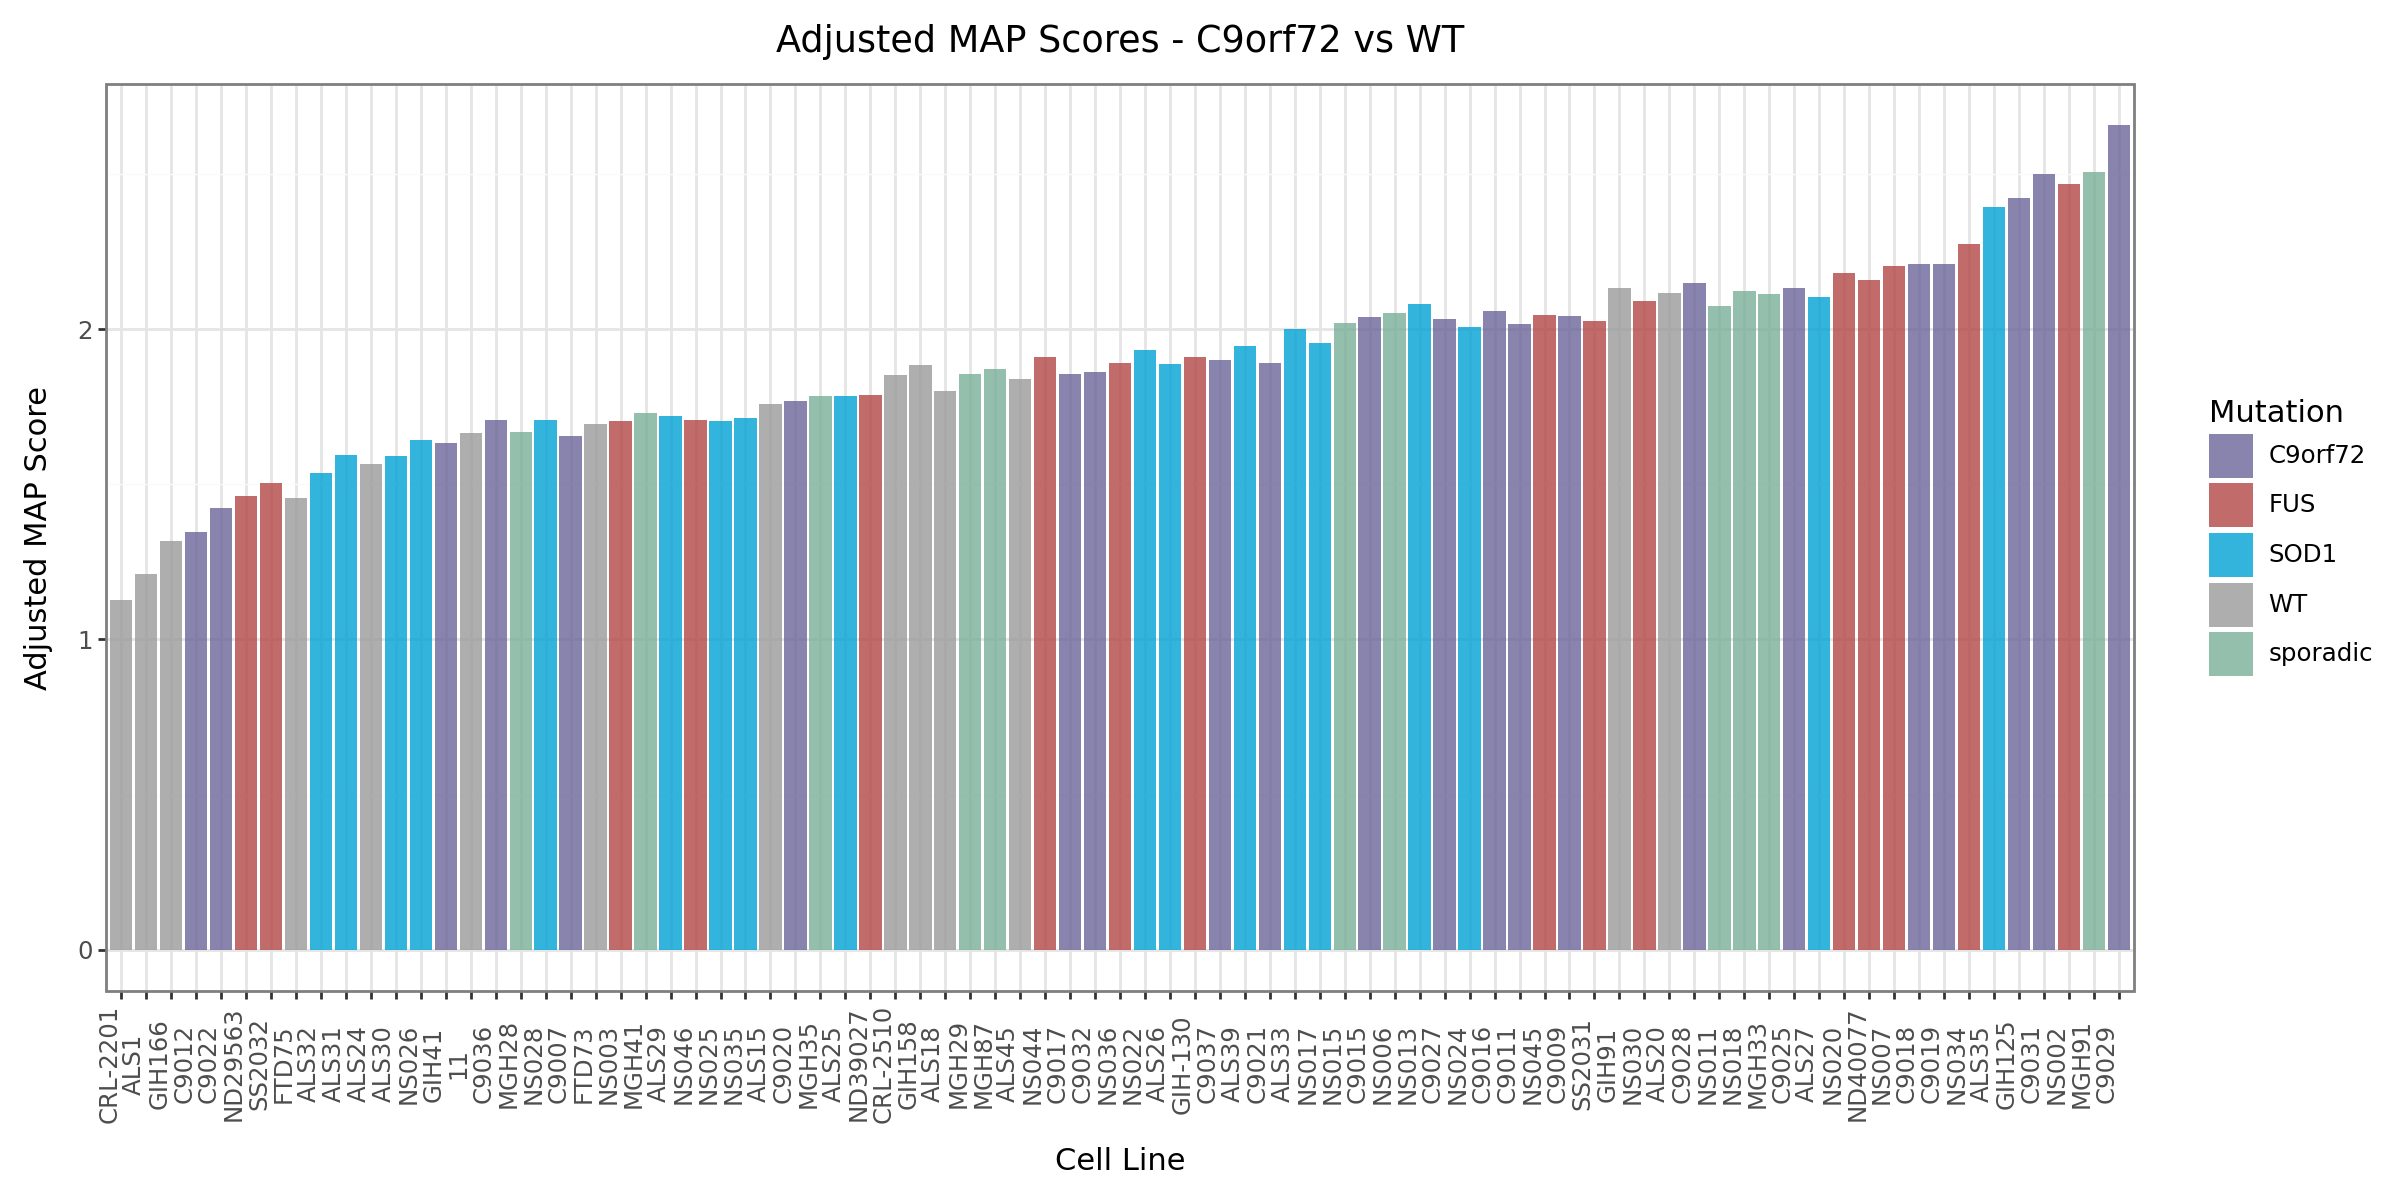


=== Adjusted MAP Scores for SOD1 ===


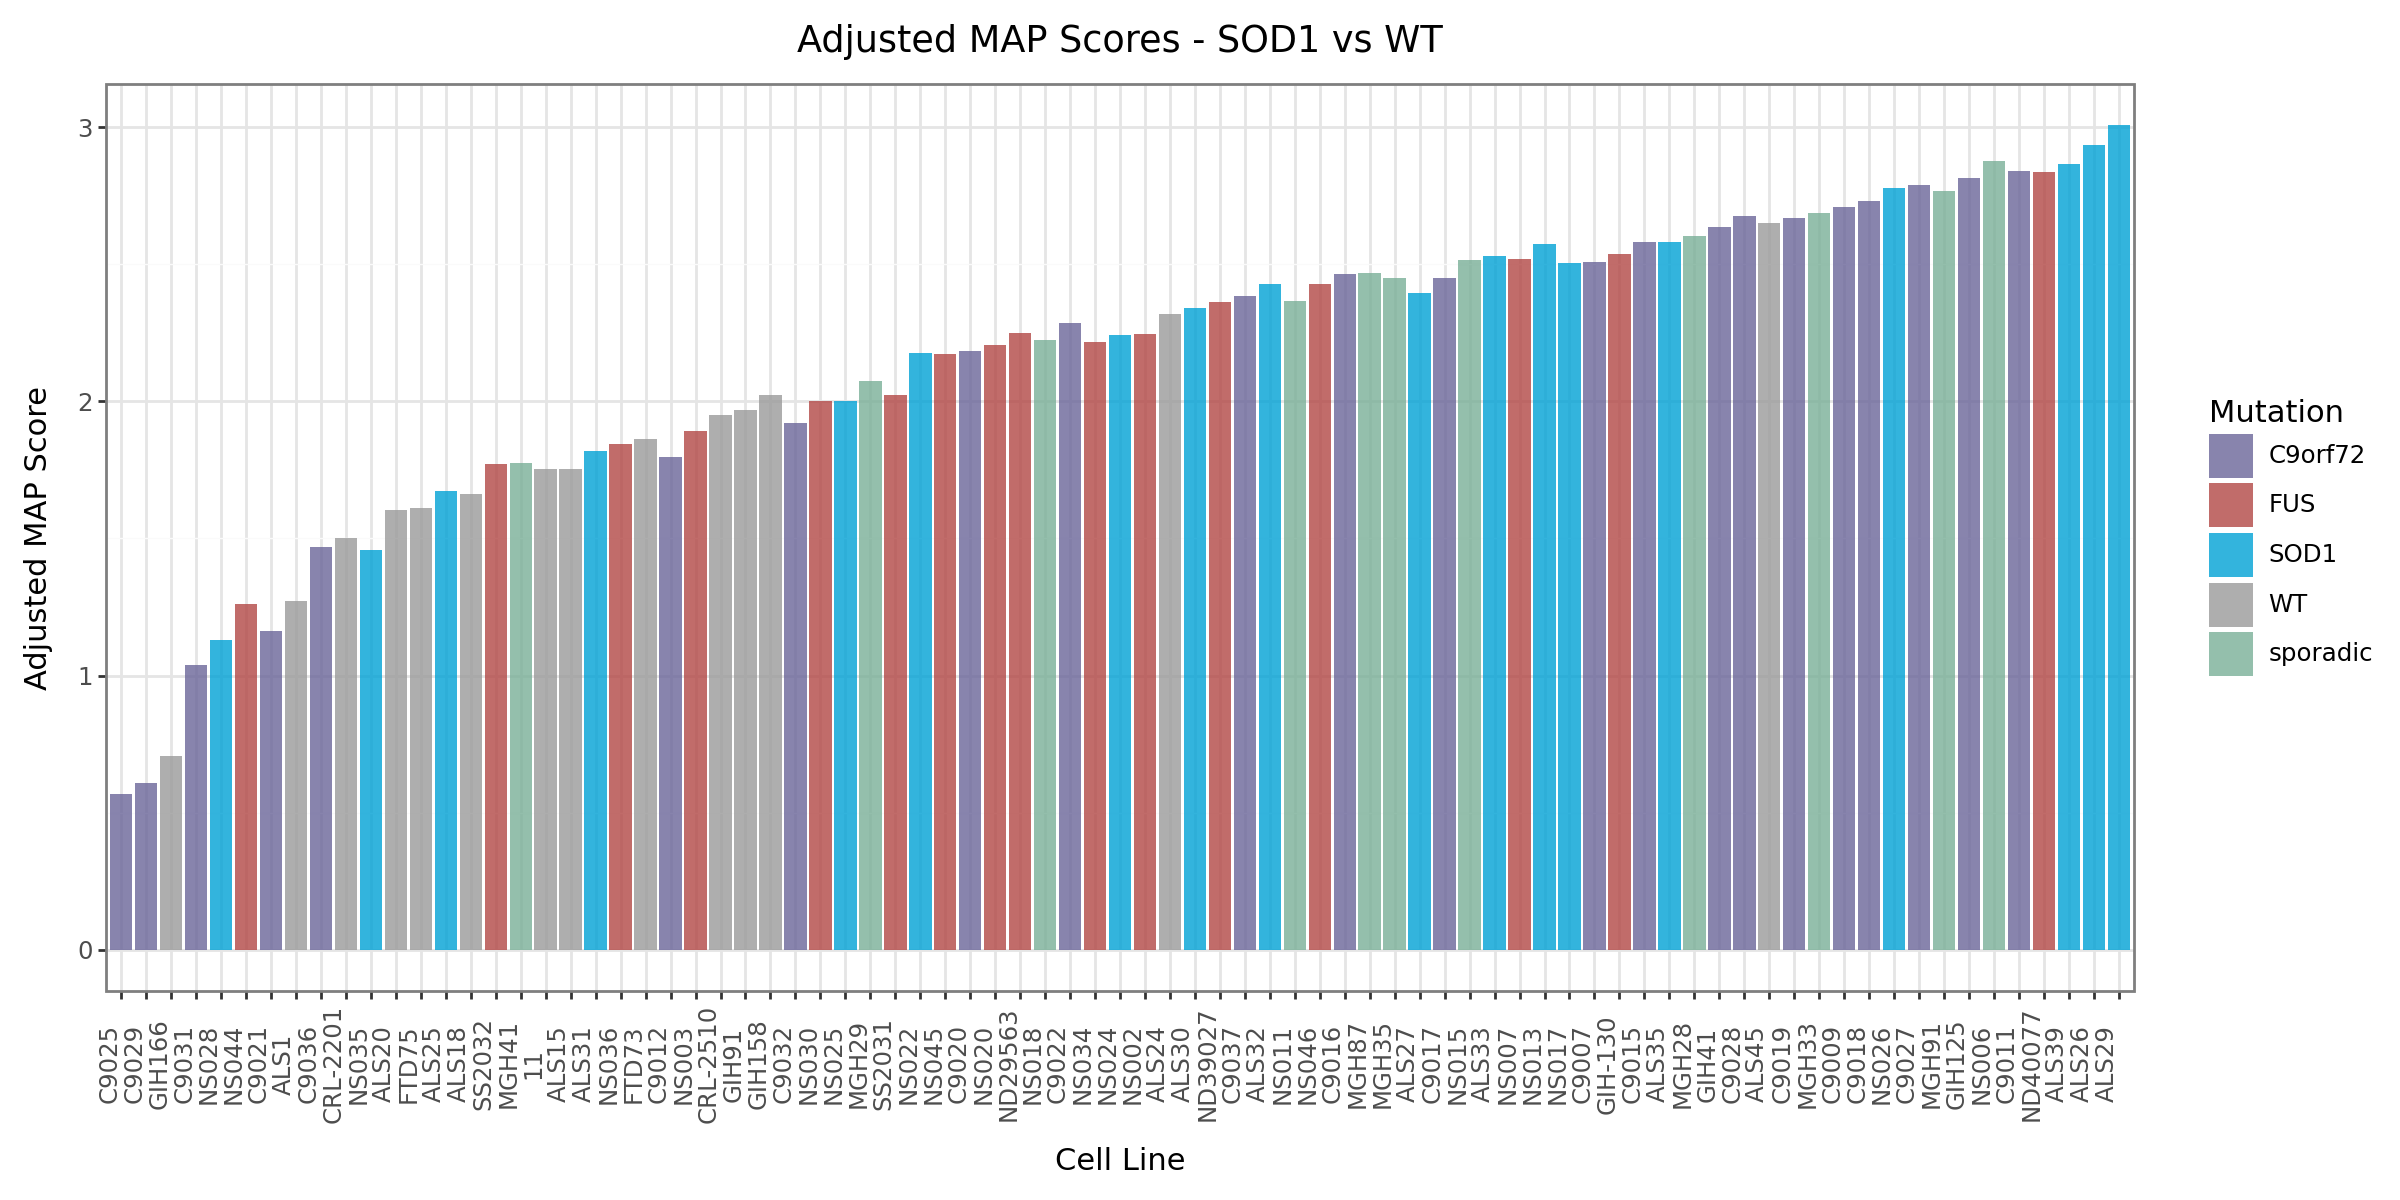


=== Adjusted MAP Scores for FUS ===


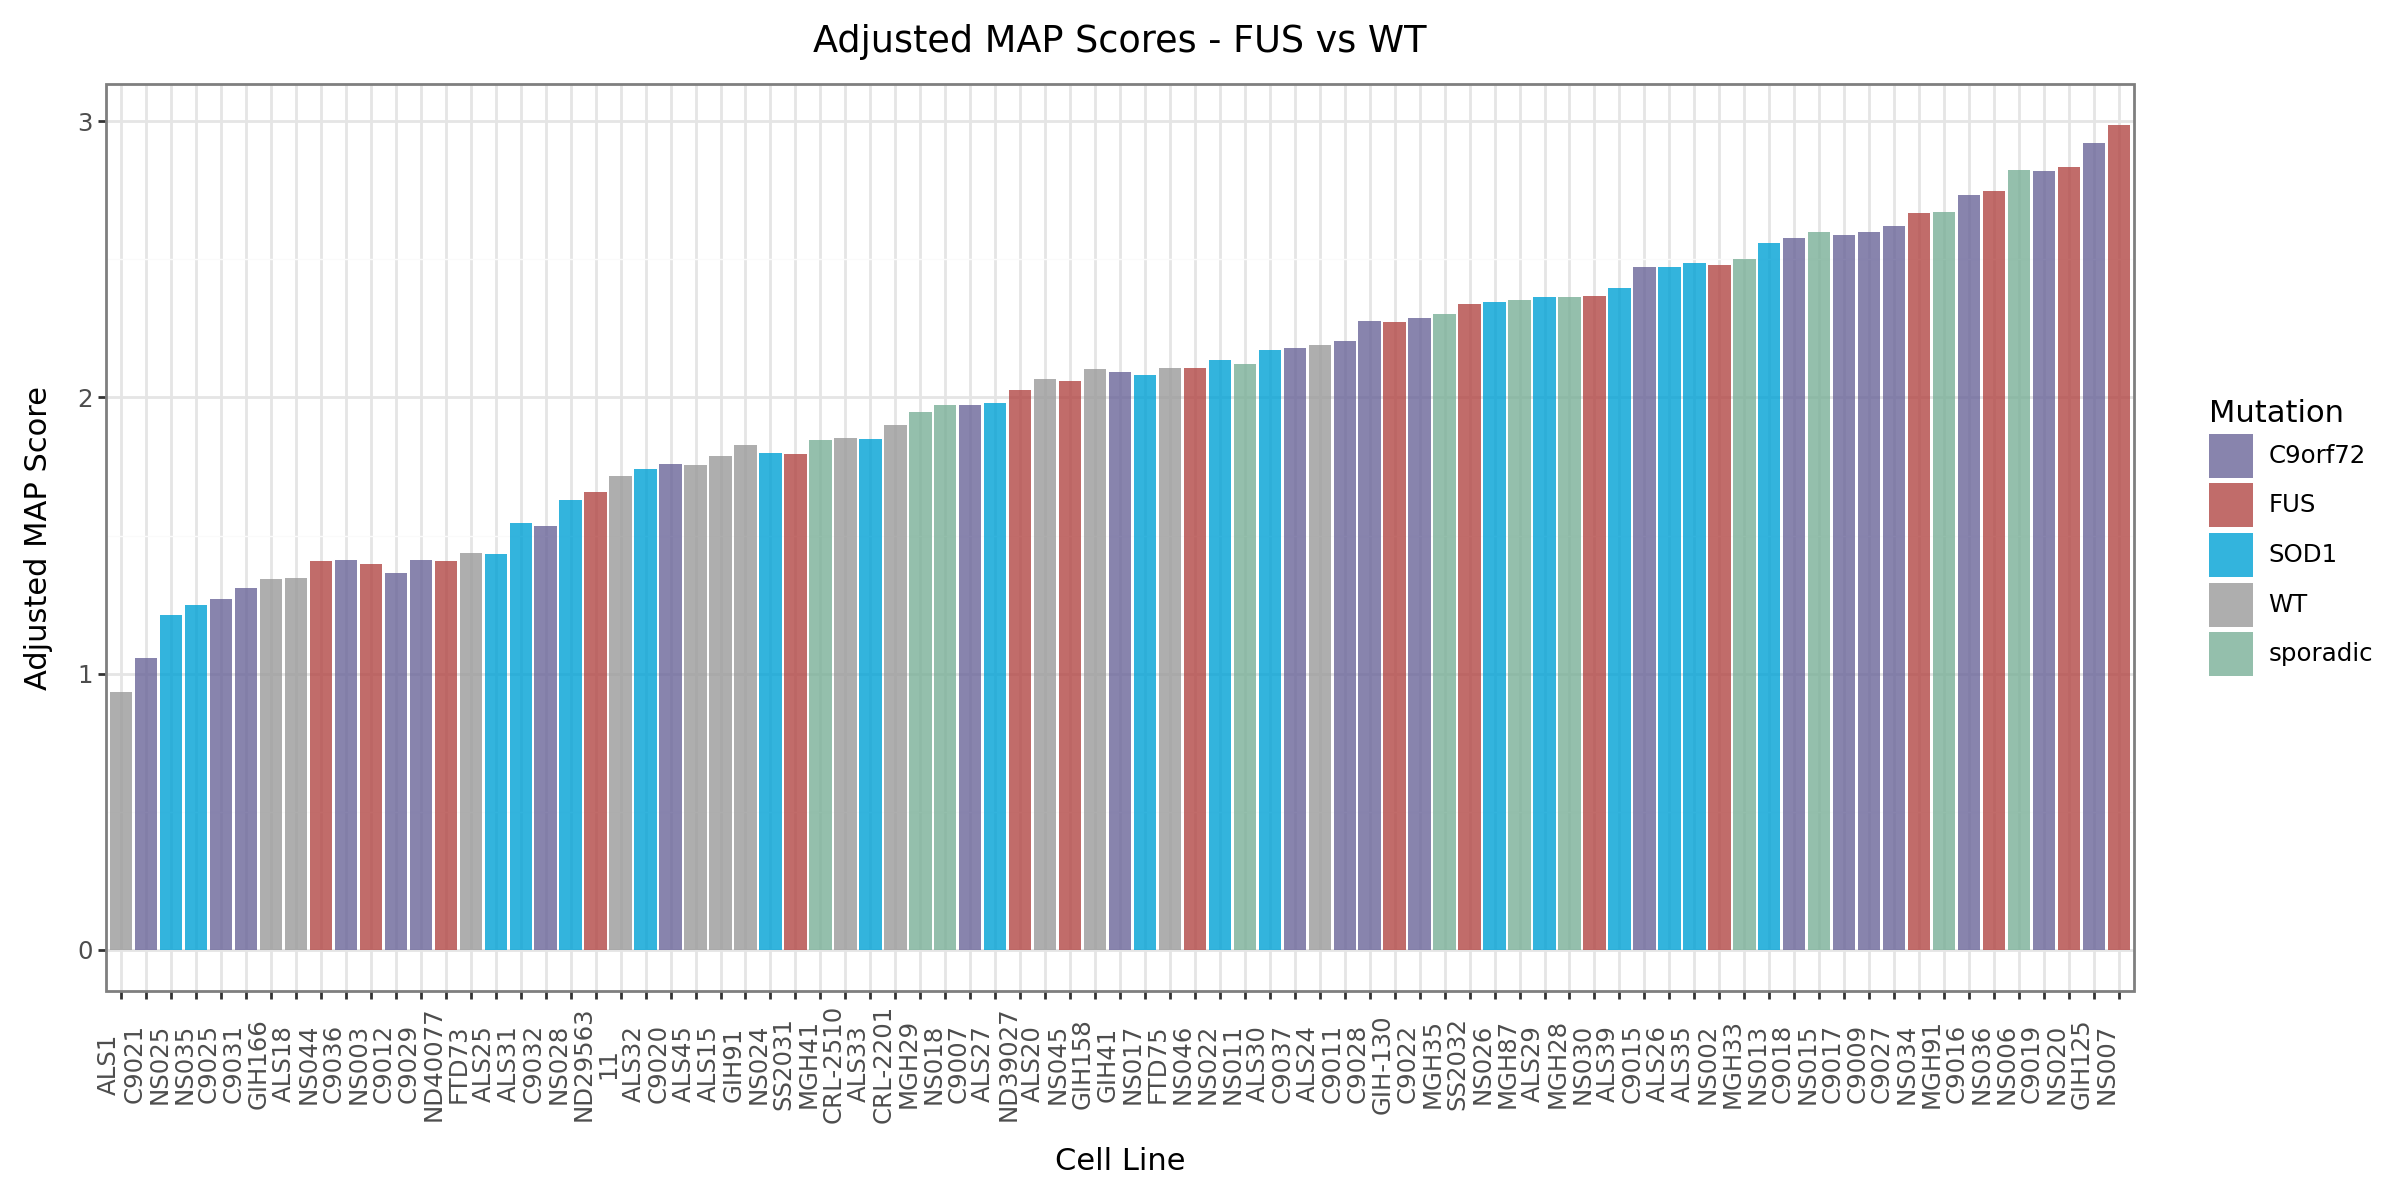

In [ ]:
from plotnine import (
    ggplot, aes, geom_bar,
    labs, theme_bw, theme, element_text,
    scale_fill_manual
)

from maps.figures import PALETTE

# Create plots for each mutation group
for k, df_adj in adjusted.items():
    print(f"\n=== Adjusted MAP Scores for {k} ===")
    
    # Convert to pandas if needed
    if hasattr(df_adj, 'to_pandas'):
        df_plot = df_adj.to_pandas()
    else:
        df_plot = df_adj.copy()
    
    # Sort by Score for better visualization
    df_plot = df_plot.sort_values('Score')
    
    # Create categorical CellLines with sorted order
    df_plot['CellLines'] = pd.Categorical(
        df_plot['CellLines'], 
        categories=df_plot['CellLines'].unique(), 
        ordered=True
    )
    
    # Create plot
    p = (
        ggplot(df_plot, aes(x='CellLines', y='Score', fill='Mutations')) +
        geom_bar(stat='identity', alpha=0.8) +
        labs(
            x='Cell Line', 
            y='Adjusted MAP Score',
            title=f'Adjusted MAP Scores - {k} vs WT',
            fill='Mutation'
        ) +
        scale_fill_manual(values=PALETTE) +
        theme_bw() +
        theme(
            axis_text_x=element_text(rotation=90, hjust=1, vjust=0.5),
            figure_size=(12, 6)
        )
    )
    
    display(p)